# Project 5B: Training Your Own Diffusion Model!

## Setup environment

In [3]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch

from PIL import Image
import mediapy as media
from pprint import pprint
from tqdm import tqdm
import os
import copy


# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [4]:
class Conv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class DownConv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class UpConv(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
       self.bn = nn.BatchNorm2d(out_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class Flatten(nn.Module):
   def __init__(self):
       super().__init__()
       self.pool = nn.AvgPool2d(7)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.pool(x))

class Unflatten(nn.Module):
   def __init__(self, in_channels: int):
       super().__init__()
       self.conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0)
       self.bn = nn.BatchNorm2d(in_channels)
       self.gelu = nn.GELU()

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.gelu(self.bn(self.conv(x)))

class ConvBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv1 = Conv(in_channels, out_channels)
       self.conv2 = Conv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.conv2(self.conv1(x))

class DownBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv_block = ConvBlock(in_channels, out_channels)
       self.down = DownConv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.down(self.conv_block(x))

class UpBlock(nn.Module):
   def __init__(self, in_channels: int, out_channels: int):
       super().__init__()
       self.conv_block = ConvBlock(in_channels, out_channels)
       self.up = UpConv(out_channels, out_channels)

   def forward(self, x: torch.Tensor) -> torch.Tensor:
       return self.up(self.conv_block(x))

## Implementing Unconditional UNet

In [ ]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int, # this is D in the diagram
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_hiddens = num_hiddens

        # operational layers
        self.opr1 = ConvBlock(self.in_channels, self.num_hiddens)
        self.opr2 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.opr3 = DownBlock(self.num_hiddens, self.num_hiddens * 2)
        self.opr4 = Flatten()
        self.opr5 = Unflatten(self.num_hiddens * 2)
        self.opr6 = UpBlock(self.num_hiddens * 4, self.num_hiddens)
        self.opr7 = UpBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr8 = ConvBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr9 = nn.Conv2d(self.num_hiddens, self.in_channels, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

       # Encoder
        x1 = self.opr1(x)
        x2 = self.opr2(x1)
        x3 = self.opr3(x2)
        x4 = self.opr4(x3)

        # Decoder
        x5 = self.opr5(x4)
        x6 = self.opr6(torch.cat([x3, x5], dim=1))
        x7 = self.opr7(torch.cat([x2, x6], dim=1))
        x8 = self.opr8(torch.cat([x1, x7], dim=1))
        x9 = self.opr9(x8)
        return x9

## Train the Model

## Helpers

In [6]:
mnist_test = MNIST(root="data", train=False, download=True, transform=ToTensor())
mnist_train = MNIST(root="data", train=True, download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.75MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 416kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.04MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.81MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
def media_image(im):
    try:
        return im.permute(1,2,0) / 2. + 0.5
    except:

        return im.transpose(1,2,0)

In [8]:
# generate z from x using the following noise process
# z = x + sigma * epsilon
# where eps ~ N(0,I)
def generate_z(x: torch.Tensor, sigma: float) -> torch.Tensor:
  return x + sigma * torch.randn_like(x)

In [9]:
sigmas = [0.0,0.2,0.4,0.5,0.6,0.8,1.0]
img_dict = {}
for j in range(5):
  for i in range(len(sigmas)):
    x = mnist_test[j][0]
    z = generate_z(x, sigmas[i])
    img_dict[f"σ = {sigmas[i]}"] = media_image(z)
  media.show_images(img_dict)

σ = 0.0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1.0


σ = 0.0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1.0


σ = 0.0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1.0


σ = 0.0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1.0


σ = 0.0,σ = 0.2,σ = 0.4,σ = 0.5,σ = 0.6,σ = 0.8,σ = 1.0


## Checkpointing Functions

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved: {path}")

def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Loaded checkpoint from epoch {epoch}")
    return epoch, loss

# 3. Use during training loop
# Define save directory in your Google Drive
save_dir = '/content/drive/MyDrive/cs180_project5/'
os.makedirs(save_dir, exist_ok=True)

OSError: [Errno 30] Read-only file system: '/content'

## 1.2.1 Training


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'mps'

In [39]:
def preview_model(model, sigmas=[0.5], n_sample=3):
  for i in range(n_sample):
    img_dict = {}
    x = mnist_test[i][0].to(device)
    img_dict['input \t |'] = media_image(x).cpu()
    for sigma in sigmas:
      z = generate_z(x, sigma).to(device)
      img_dict[f'Noisy (σ = {sigma}) \t |'] = media_image(z).cpu()
      result = model(z.unsqueeze(0))[0].cpu()
      img_dict["Output"] = media_image(result).detach()
    media.show_images(img_dict)
    print("\n")

In [347]:
def plot_loss_curve(losses, logscale=True):
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Losses')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    if logscale:
        plt.yscale('log')  # Use log scale like in the example
    plt.grid(True)
    plt.show()

In [80]:
def plot_loss_curve_scatter(losses):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(losses)), losses, s=1)
    plt.title('Training Losses')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale like in the example
    plt.grid(True)
    plt.show()

In [67]:
def train(sigma=0.5, training_set_non_loaded=None):
  # shuffle training set and create data loader
  batch_size = 256
  training_set = torch.utils.data.DataLoader(training_set_non_loaded, batch_size=256, shuffle=True)

  # model and hyperparameters
  print("device: ", device)
  num_hiddens = 128
  learning_rate = 1e-4
  model = UnconditionalUNet(in_channels=1, num_hiddens=num_hiddens)
  model.train()
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  loss_fn = nn.functional.mse_loss
  model_epoch1 = None

  # training loop
  losses = []
  num_epochs = 5
  for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (clean_images, _) in enumerate(training_set):
      clean_images = clean_images.to(device)
      z = generate_z(clean_images, sigma).to(device)
      optimizer.zero_grad()

      # forward pass and compute loss -- denoise the image using the model and compare
      denoised_prediction = model(z)
      loss = loss_fn(denoised_prediction, clean_images)

      # backward pass, optimize, track loss
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      losses.append(loss.item())

      # Print progress every 100 batches
      if batch_idx % 100 == 0:
          print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.6f}')

    # visualize results for first 3 data points for 1rst and 5th epoch
    # alternatively save it
    if epoch == 0: model_epoch1 = model
    try:
      if epoch == 0 or epoch == 4: preview_model(model)
    except: pass

    # Save checkpoint
    epoch_loss = total_loss / len(training_set)
    print(f'Epoch {epoch} complete. Average loss: {epoch_loss:.6f}')
    checkpoint_path = f'unet_checkpoint_epoch{epoch}.pt'
    try: save_checkpoint(model, optimizer, epoch, epoch_loss, checkpoint_path)
    except: pass 

  try: 
    plot_loss_curve(losses)
  except: print("Error plotting loss curve")
  model.eval(), model_epoch1.eval()
  return model, losses, model_epoch1

## Deliverables

device:  mps
Epoch: 0, Batch: 0, Loss: 0.441406


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output




Epoch 0 complete. Average loss: 0.078113
Checkpoint saved: unet_checkpoint_epoch0.pt
Epoch: 1, Batch: 0, Loss: 0.019718
Epoch 1 complete. Average loss: 0.017313
Checkpoint saved: unet_checkpoint_epoch1.pt
Epoch: 2, Batch: 0, Loss: 0.015416
Epoch 2 complete. Average loss: 0.014648
Checkpoint saved: unet_checkpoint_epoch2.pt
Epoch: 3, Batch: 0, Loss: 0.013459
Epoch 3 complete. Average loss: 0.013429
Checkpoint saved: unet_checkpoint_epoch3.pt
Epoch: 4, Batch: 0, Loss: 0.013123


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output


input |,Noisy (σ = 0.5) |,Output




Epoch 4 complete. Average loss: 0.012821
Checkpoint saved: unet_checkpoint_epoch4.pt


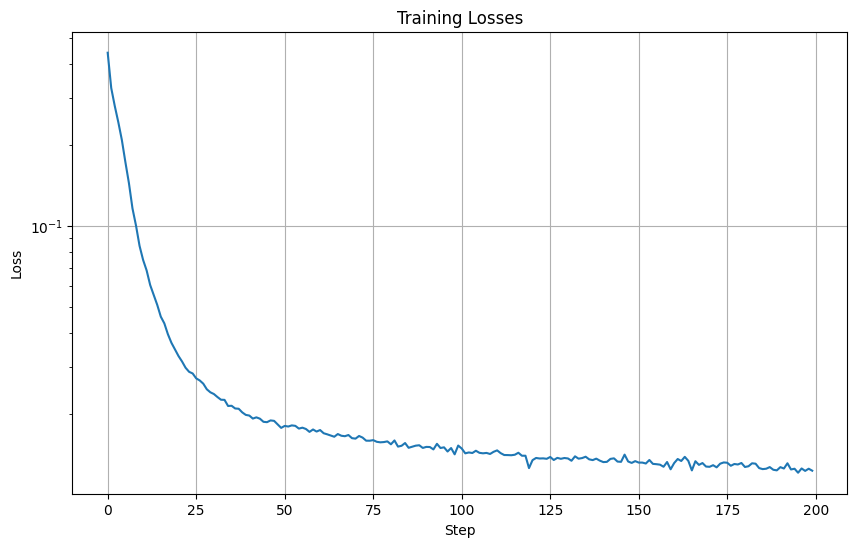

In [68]:
model, losses, model_epoch1 = train(sigma=0.5, training_set_non_loaded=mnist_train)

## 1.2.2 Out of Distribution Testing

In [73]:
sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
x = mnist_test[0][0].to(device)

img_dict_1 = {}
img_dict_2 = {}
for sigma in sigmas:
  z = generate_z(x, sigma).to(device)
  img_dict_1[f'Noisy (σ = {sigma}) \t |'] = media_image(z).cpu()
  result = model(z.unsqueeze(0))[0].cpu()
  img_dict_2[f"Output (σ = {sigma}) \t |"] = media_image(result).detach()
media.show_images(img_dict_1)
media.show_images(img_dict_2)

Noisy (σ = 0.0) |,Noisy (σ = 0.2) |,Noisy (σ = 0.4) |,Noisy (σ = 0.5) |,Noisy (σ = 0.6) |,Noisy (σ = 0.8) |,Noisy (σ = 1.0) |


Output (σ = 0.0) |,Output (σ = 0.2) |,Output (σ = 0.4) |,Output (σ = 0.5) |,Output (σ = 0.6) |,Output (σ = 0.8) |,Output (σ = 1.0) |


# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [307]:
a = torch.Tensor([[[[2]]],[[[3]]]])
print(a.shape)
a.expand(-1,-1,-1,2)

torch.Size([2, 1, 1, 1])


tensor([[[[2., 2.]]],


        [[[3., 3.]]]])

In [497]:
m = nn.Linear(10, 30)
input = torch.randn(128, 10)
print(input.shape)
output = m(input)
print(len(output.size()))
torch.Size([128, 30])


torch.Size([128, 10])
2


torch.Size([128, 30])

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear2(self.gelu(self.linear(x.to(device))))


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens

        # operational layers
        self.opr1 = ConvBlock(self.in_channels, self.num_hiddens)
        self.opr2 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.opr3 = DownBlock(self.num_hiddens, self.num_hiddens * 2)
        self.opr4 = Flatten()
        self.opr5 = Unflatten(self.num_hiddens * 2)
        self.opr6 = UpBlock(self.num_hiddens * 4, self.num_hiddens)
        self.opr7 = UpBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr8 = ConvBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr9 = nn.Conv2d(self.num_hiddens, self.in_channels, kernel_size=3, stride=1, padding=1)

        self.fc1 = FCBlock(1, self.num_hiddens * 2)
        self.fc2 = FCBlock(1, self.num_hiddens)

    # make t in the right shape (N, 2D, 1, 1)
    # dimensions are tricky here: [N] -> [N, 1] --fc--> [N, 2D] --> [N, 2D, 1, 1] --> [N, 2D, 7, 7]
    # or the second one to [N,D,14,14]
    def apply_fc_block(obj, fc_block):
        print(obj.shape)
        obj = obj.unsqueeze(-1) # [N] -> [N, 1]
        obj = fc_block(obj) # [N, 1] -> [N, 2D]
        obj = obj.unsqueeze(-1).unsqueeze(-1) # [N, 2D] -> [N, 2D, 1, 1]
        return obj

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        # Encoder
        x1 = self.opr1(x)
        x2 = self.opr2(x1)
        x3 = self.opr3(x2)
        x4 = self.opr4(x3)

        # Decoder
        x_ = self.opr5(x4)
        t1 = TimeConditionalUNet.apply_fc_block(t, self.fc1)
        x5 = x_ + t1

        x_ = self.opr6(torch.cat([x3, x5], dim=1))
        t2 = TimeConditionalUNet.apply_fc_block(t, self.fc2)
        x6 = x_ + t2

        x7 = self.opr7(torch.cat([x2, x6], dim=1))
        x8 = self.opr8(torch.cat([x1, x7], dim=1))
        x9 = self.opr9(x8)
        return x9

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

### DDPM


In [309]:
torch.linspace(0,1,5)

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

#### Schedule

In [310]:
betas_key = "betasz"

In [311]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    # create a list of betas between beta1 and beta2 evenly spaced then get betas and alpha bars
    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return {
        betas_key: betas,
        "alphas": alphas,
        "alpha_bars": alpha_bars,
    }

#### DDPM Forward Process

In [312]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor. you can use this directly without looping over it since the model can take batches of images
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    # we sample a random t because we don't want the model to overfit based on sequential patterns, but also want it to learn the relationship between t and the noise prediction
    t_idx = torch.randint(0, num_ts, (x_0.shape[0],))
    t = t_idx

    # get x_t
    eps = torch.randn_like(x_0)
    alpha_bar = ddpm_schedule['alpha_bars'][t_idx].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(device) # size N
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps

    # predict epsilon via unet
    # normalize t based on recommendation on writeup
    predicted_eps = unet(x_t, t / num_ts)

    # compute loss, perform gradient descent
    loss = torch.nn.functional.mse_loss(predicted_eps, eps)
    return loss

In [313]:
torch.Tensor([5])

tensor([5.])

#### DDPM Sampling

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    torch.manual_seed(seed)
    x_t = torch.randn(1, 1, img_wh[0], img_wh[1]).to(device)
    old = None 
    for t in reversed(range(1, num_ts)):
        random_noise = torch.randn_like(x_t).to(device) if t > 1 else 0
        predicted_conditional_noise = unet(x_t, torch.Tensor([t / num_ts])) # normalized t because that is how we trained the unet model.

        # alphas and betas
        alpha_bar_t_minus_one = ddpm_schedule['alpha_bars'][t - 1]
        alpha_bar_t = ddpm_schedule['alpha_bars'][t]
        alpha_t = ddpm_schedule['alphas'][t]
        beta_t = ddpm_schedule[betas_key][t]

        # calculate x_0
        division_factor = torch.sqrt(alpha_bar_t)
        coeff2 = torch.sqrt(1 - alpha_bar_t)
        x_0 = (x_t - coeff2 * predicted_conditional_noise) / division_factor

        # calculate x_{t-1}
        division_factor = 1 - alpha_bar_t
        coeff1 = torch.sqrt(alpha_bar_t_minus_one) * beta_t
        coeff2 = torch.sqrt(alpha_t) * (1 - alpha_bar_t_minus_one)
        coeff3 = torch.sqrt(beta_t)
        x_t = (coeff1 * x_0 + coeff2 * x_t) / division_factor + coeff3 * random_noise
    return x_t

#### DDPM class

In [315]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

### Train

In [ ]:
def train_diffusion(training_set_non_loaded=None, num_epochs=20):
  # shuffle training set and create data loader
  batch_size = 128
  training_set = torch.utils.data.DataLoader(training_set_non_loaded, batch_size=batch_size, shuffle=True)

  # model and hyperparameters
  print("device: ", device)
  num_hiddens = 64
  learning_rate = 1e-3
  unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=num_hiddens).to(device)
  model = DDPM(unet).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, pow(0.1, 1.0 / num_epochs))
  model_epoch5 = None

  # training loop
  losses = []
  for epoch in range(1, num_epochs + 1):
    model.train()
    for clean_images, _ in tqdm(training_set):
      # forward pass and compute loss -- predict the noise
      optimizer.zero_grad()
      clean_images = clean_images.to(device)
      predicted_loss = model(clean_images)
      predicted_loss.backward()
      optimizer.step()
      losses.append(predicted_loss.item())

    scheduler.step() # adjust learning rate after each epoch

    # visualize results for first 3 data points for 5th and last epoch
    # alternatively save it
    if epoch == 5: model_epoch5 = copy.deepcopy(model)
    try:
      if epoch == 5 or epoch == num_epochs: preview_model(model)
    except: pass    
    print(f'Epoch {epoch} complete. last loss: {predicted_loss.item():.6f}')

  try: 
    plot_loss_curve(losses)
  except: print("Error plotting loss curve")
  return model, losses, model_epoch5

device:  mps


100%|██████████| 469/469 [00:39<00:00, 11.83it/s]


Epoch 1 complete. last loss: 0.044203


100%|██████████| 469/469 [00:35<00:00, 13.08it/s]


Epoch 2 complete. last loss: 0.039255


100%|██████████| 469/469 [00:35<00:00, 13.29it/s]


Epoch 3 complete. last loss: 0.036428


100%|██████████| 469/469 [00:35<00:00, 13.10it/s]


Epoch 4 complete. last loss: 0.037005


100%|██████████| 469/469 [00:36<00:00, 12.75it/s]


Epoch 5 complete. last loss: 0.032426


100%|██████████| 469/469 [00:37<00:00, 12.36it/s]


Epoch 6 complete. last loss: 0.031780


100%|██████████| 469/469 [00:38<00:00, 12.20it/s]


Epoch 7 complete. last loss: 0.028313


100%|██████████| 469/469 [00:38<00:00, 12.07it/s]


Epoch 8 complete. last loss: 0.025934


100%|██████████| 469/469 [00:37<00:00, 12.47it/s]


Epoch 9 complete. last loss: 0.028855


100%|██████████| 469/469 [00:36<00:00, 12.79it/s]


Epoch 10 complete. last loss: 0.029367


100%|██████████| 469/469 [00:35<00:00, 13.06it/s]


Epoch 11 complete. last loss: 0.028744


100%|██████████| 469/469 [00:35<00:00, 13.24it/s]


Epoch 12 complete. last loss: 0.034593


100%|██████████| 469/469 [00:35<00:00, 13.08it/s]


Epoch 13 complete. last loss: 0.027824


100%|██████████| 469/469 [00:35<00:00, 13.23it/s]


Epoch 14 complete. last loss: 0.025853


100%|██████████| 469/469 [00:35<00:00, 13.33it/s]


Epoch 15 complete. last loss: 0.031123


100%|██████████| 469/469 [00:34<00:00, 13.43it/s]


Epoch 16 complete. last loss: 0.034049


100%|██████████| 469/469 [00:34<00:00, 13.60it/s]


Epoch 17 complete. last loss: 0.029757


100%|██████████| 469/469 [00:34<00:00, 13.48it/s]


Epoch 18 complete. last loss: 0.027742


100%|██████████| 469/469 [00:34<00:00, 13.71it/s]


Epoch 19 complete. last loss: 0.030461


100%|██████████| 469/469 [00:33<00:00, 13.81it/s]

Epoch 20 complete. last loss: 0.030581


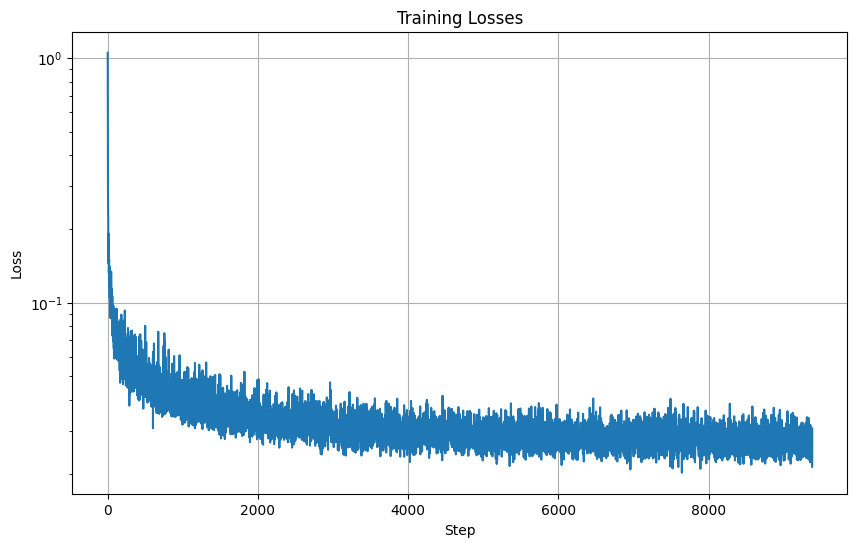

In [317]:
model, losses, model_epoch5 = train_diffusion(training_set_non_loaded=mnist_train, num_epochs=20)

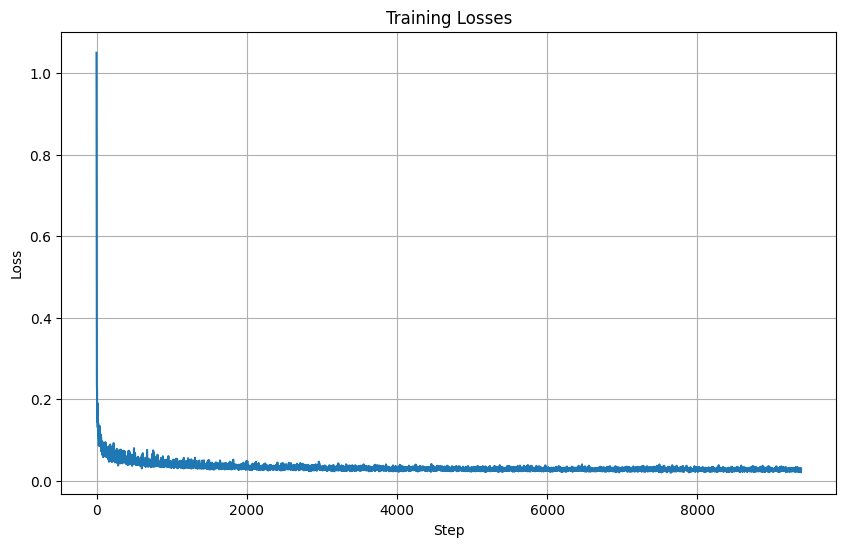

In [348]:
plot_loss_curve(losses, False)

### Sampling from the time-conditioned unet

In [505]:
import random 
def reset_random():
    seed = random.randint(0, 2**32 - 1)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def sample_at_seed(model, seed, img_wh=(28,28), show_img=True): 
    x_t = model.sample(img_wh, seed)
    if show_img:
        media.show_image(media_image(x_t[0]).cpu())
    return x_t

# print in rows of 10 
def sample_at_random_seeds(model, img_wh=(28,28), n_rows=4, print_seed=False): 
    for i in range(n_rows):
        reset_random()  # reset random seed
        row_imgs = []
        for j in range(10):
            seed = random.randint(0, 2**32 - 1)
            if print_seed: print(seed)
            x_t = sample_at_seed(model, seed, img_wh, show_img=False)
            row_imgs.append(media_image(x_t[0]).cpu())
        media.show_images(row_imgs)

In [506]:
sample_at_random_seeds(model) 

TypeError: 'int' object is not subscriptable

In [365]:
sample_at_random_seeds(model_epoch5)

,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


### Implementing class-conditioned UNet

In [590]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens

        # operational layers
        self.opr1 = ConvBlock(self.in_channels, self.num_hiddens)
        self.opr2 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.opr3 = DownBlock(self.num_hiddens, self.num_hiddens * 2)
        self.opr4 = Flatten()
        self.opr5 = Unflatten(self.num_hiddens * 2)
        self.opr6 = UpBlock(self.num_hiddens * 4, self.num_hiddens)
        self.opr7 = UpBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr8 = ConvBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr9 = nn.Conv2d(self.num_hiddens, self.in_channels, kernel_size=3, stride=1, padding=1)

        self.fc1_t = FCBlock(1, self.num_hiddens * 2)
        self.fc2_t = FCBlock(1, self.num_hiddens)
        self.fc1_c = FCBlock(self.num_classes, self.num_hiddens * 2)
        self.fc2_c = FCBlock(self.num_classes, self.num_hiddens)
        
    # make t in the right shape (N, 2D, 1, 1)
    # dimensions are tricky here: [N] -> [N, 1] --fc--> [N, 2D] --> [N, 2D, 1, 1] --> [N, 2D, 7, 7]
    # or the second one to [N,D,14,14]
    def apply_fc_block(obj, fc_block):
        if (len(obj.size())) == 1: obj = obj.unsqueeze(-1) # [N] -> [N, 1]
        obj = fc_block(obj) # [N,1] -> [N,2D]
                            # otherwise [N, 10] -> [N, 2D]      
        obj = obj.unsqueeze(-1).unsqueeze(-1) # [N, 2D] -> [N, 2D, 1, 1]
        return obj
    
    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,num_classes) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        # apply masking if needed 
        if mask == 0 or c is None: 
            c = torch.zeros_like(c)
        c = c.float().to(t.device)
            
        # Encoder
        x1 = self.opr1(x)
        x2 = self.opr2(x1)
        x3 = self.opr3(x2)
        x4 = self.opr4(x3)

        # Decoder
        x_ = self.opr5(x4)
        t1 = ClassConditionalUNet.apply_fc_block(t, self.fc1_t)
        c1 = ClassConditionalUNet.apply_fc_block(c, self.fc1_c)
        x5 = c1 * x_ + t1

        x_ = self.opr6(torch.cat([x3, x5], dim=1))
        t2 = ClassConditionalUNet.apply_fc_block(t, self.fc2_t)
        c2 = ClassConditionalUNet.apply_fc_block(c, self.fc2_c)
        x6 = c2 * x_ + t2

        x7 = self.opr7(torch.cat([x2, x6], dim=1))
        x8 = self.opr8(torch.cat([x1, x7], dim=1))
        x9 = self.opr9(x8)
        return x9

In [389]:
a = torch.zeros((2,6))
b = torch.Tensor([5,2])
# for each i in a, a[i][b[i]] = 1 but vectorized
a[torch.arange(a.size(0)), b.long()] = 1
a

tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.]])

In [ ]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    num_classes = unet.num_classes
    def get_mnist_one_hot_vector(digits): 
        one_hot = torch.zeros((digits.shape[0], num_classes)).to(device)
        # one_hot[i][digits[i]] = 1
        one_hot[torch.arange(one_hot.size(0)).to(device), digits.long()] = 1
        return one_hot.float()
        
    def get_dropout_condition():
        choices = [True, False]
        return random.choices(choices, weights=[p_uncond, 1 - p_uncond])[0]
    
    # we sample a random t because we don't want the model to overfit based on sequential patterns, but also want it to learn the relationship between t and the noise prediction
    t_idx = torch.randint(0, num_ts, (x_0.shape[0],))
    t = t_idx
    
    # get x_t
    eps = torch.randn_like(x_0)
    alpha_bar = ddpm_schedule['alpha_bars'][t_idx].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(device) # size N
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps
    
    # predict epsilon via unet
    # normalize t based on recommendation on writeup
    c_vector = get_mnist_one_hot_vector(c)
    mask = None if not get_dropout_condition() else 0
    predicted_eps = unet(x_t, c=c_vector, t=t / num_ts, mask=mask).float()
        
    # compute loss, perform gradient descent
    loss = torch.nn.functional.mse_loss(predicted_eps, eps)
    return loss

In [618]:

@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        # c: (N,) int64 condition tensor. Only for class-conditional
        # c: (num_classes=10,) int64 condition tensor. Only for class-conditional NOTE: one hot vector
        c: (1,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, Ch, H, W) final sample.
        # (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # YOUR CODE HERE.
    # make c into a one hot vector if it is only dimension 
    if c.size() == torch.Size([1]):
        a = torch.zeros(unet.num_classes)
        a[c[0].long()] = 1 
        c = a.unsqueeze(0)
        
    torch.manual_seed(seed)
    x_t = torch.randn(1, 1, img_wh[0], img_wh[1]).to(device)
    for t in reversed(range(1, num_ts)):
        random_noise = torch.randn_like(x_t).to(device) if t > 1 else 0
        
        # cfg noise 
        predicted_unconditional_noise = unet(x_t, c=c, t=torch.Tensor([t / num_ts]), mask=0)
        predicted_conditional_noise = unet(x_t, c=c, t=torch.Tensor([t / num_ts])) # normalized t because that is how we trained the unet model.
        noise_est = predicted_unconditional_noise + guidance_scale * (predicted_conditional_noise - predicted_unconditional_noise) 

        # alphas and betas
        alpha_bar_t_minus_one = ddpm_schedule['alpha_bars'][t - 1]
        alpha_bar_t = ddpm_schedule['alpha_bars'][t]
        alpha_t = ddpm_schedule['alphas'][t]
        beta_t = ddpm_schedule[betas_key][t]

        # calculate x_0
        division_factor = torch.sqrt(alpha_bar_t)
        coeff2 = torch.sqrt(1 - alpha_bar_t)
        x_0 = (x_t - coeff2 * noise_est) / division_factor

        # calculate x_{t-1}
        division_factor = 1 - alpha_bar_t
        coeff1 = torch.sqrt(alpha_bar_t_minus_one) * beta_t
        coeff2 = torch.sqrt(alpha_t) * (1 - alpha_bar_t_minus_one)
        coeff3 = torch.sqrt(beta_t)
        x_t = (coeff1 * x_0 + coeff2 * x_t) / division_factor + coeff3 * random_noise
        
        
        # ========================
        
        # ========================
    return x_t

In [399]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

### Train


In [400]:
def train_diffusion_class(training_set_non_loaded=None, num_epochs=20):
  # shuffle training set and create data loader
  batch_size = 128
  training_set = torch.utils.data.DataLoader(training_set_non_loaded, batch_size=batch_size, shuffle=True)

  # model and hyperparameters
  print("device: ", device)
  num_hiddens = 64
  learning_rate = 1e-3
  unet = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=num_hiddens).to(device)
  model = DDPM(unet).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, pow(0.1, 1.0 / num_epochs))
  model_epoch5 = None

  # training loop
  losses = []
  for epoch in range(1, num_epochs + 1):
    model.train()
    for clean_images, digits in tqdm(training_set):
      # forward pass and compute loss -- predict the noise
      optimizer.zero_grad()
      clean_images, digits = clean_images.to(device), digits.to(device)
      predicted_loss = model(clean_images, digits)
      predicted_loss.backward()
      optimizer.step()
      losses.append(predicted_loss.item())

    scheduler.step() # adjust learning rate after each epoch

    # visualize results for first 3 data points for 5th and last epoch
    # alternatively save it
    if epoch == 5: model_epoch5 = copy.deepcopy(model)
    try:
      if epoch == 5 or epoch == num_epochs: preview_model(model)
    except: pass
    print(f'Epoch {epoch} complete. last loss: {predicted_loss.item():.6f}')

  try: 
    plot_loss_curve(losses)
  except: print("Error plotting loss curve")
  return model, losses, model_epoch5

device:  mps


100%|██████████| 469/469 [00:36<00:00, 13.01it/s]


Epoch 1 complete. last loss: 0.047061


100%|██████████| 469/469 [00:36<00:00, 13.01it/s]


Epoch 2 complete. last loss: 0.034603


100%|██████████| 469/469 [00:35<00:00, 13.12it/s]


Epoch 3 complete. last loss: 0.030303


100%|██████████| 469/469 [00:35<00:00, 13.23it/s]


Epoch 4 complete. last loss: 0.031201


100%|██████████| 469/469 [00:35<00:00, 13.12it/s]


Epoch 5 complete. last loss: 0.033217


100%|██████████| 469/469 [00:34<00:00, 13.41it/s]


Epoch 6 complete. last loss: 0.029833


100%|██████████| 469/469 [00:35<00:00, 13.31it/s]


Epoch 7 complete. last loss: 0.036779


100%|██████████| 469/469 [00:34<00:00, 13.45it/s]


Epoch 8 complete. last loss: 0.024644


100%|██████████| 469/469 [00:35<00:00, 13.33it/s]


Epoch 9 complete. last loss: 0.025111


100%|██████████| 469/469 [00:34<00:00, 13.43it/s]


Epoch 10 complete. last loss: 0.022097


100%|██████████| 469/469 [00:35<00:00, 13.39it/s]


Epoch 11 complete. last loss: 0.026609


100%|██████████| 469/469 [00:35<00:00, 13.35it/s]


Epoch 12 complete. last loss: 0.027626


100%|██████████| 469/469 [00:35<00:00, 13.37it/s]


Epoch 13 complete. last loss: 0.025677


100%|██████████| 469/469 [00:34<00:00, 13.41it/s]


Epoch 14 complete. last loss: 0.027019


100%|██████████| 469/469 [00:35<00:00, 13.36it/s]


Epoch 15 complete. last loss: 0.025673


100%|██████████| 469/469 [00:34<00:00, 13.43it/s]


Epoch 16 complete. last loss: 0.022879


100%|██████████| 469/469 [00:35<00:00, 13.39it/s]


Epoch 17 complete. last loss: 0.022570


100%|██████████| 469/469 [00:34<00:00, 13.40it/s]


Epoch 18 complete. last loss: 0.028757


100%|██████████| 469/469 [00:34<00:00, 13.40it/s]


Epoch 19 complete. last loss: 0.025381


100%|██████████| 469/469 [00:34<00:00, 13.42it/s]


Epoch 20 complete. last loss: 0.025230


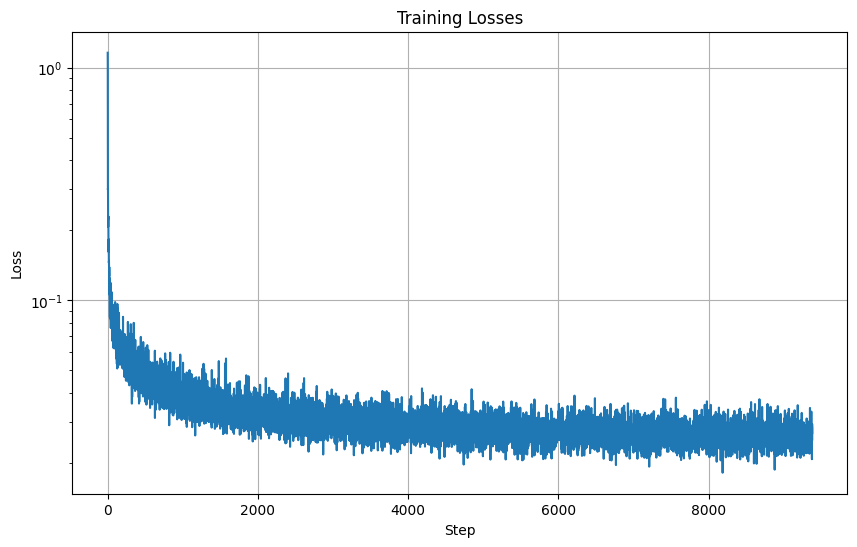

In [615]:
class_conditional_model, class_conditional_losses, class_conditional_model_epoch5 = train_diffusion_class(training_set_non_loaded=mnist_train, num_epochs=20)

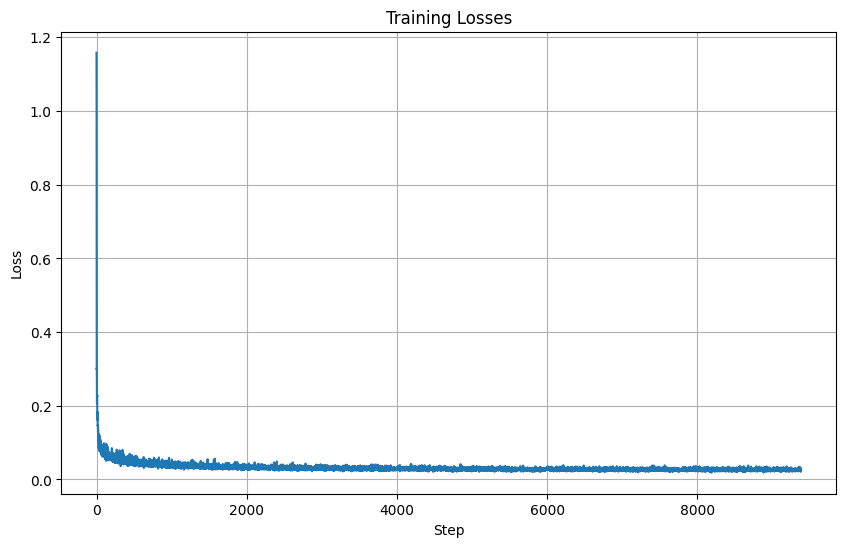

In [620]:
plot_loss_curve(class_conditional_losses, False)

### Sample

In [616]:
def sample_at_seed_class_cond(model, seed, img_wh=(28,28), show_img=True, sampling_number=None): 
    x_t = model.sample(torch.Tensor([sampling_number]), img_wh, seed)
    if show_img:
        media.show_image(media_image(x_t[0]).cpu())
    return x_t

# print in rows of 10 
def sample_at_random_seeds_class_cond(model, img_wh=(28,28), n_rows=4, print_seed=False): 
    for i in range(n_rows):
        reset_random()  # reset random seed
        row_imgs = []
        for j in range(10):
            sampling_number = j 
            seed = random.randint(0,10)
            if print_seed: print(seed)
            x_t = sample_at_seed_class_cond(model, seed, img_wh, show_img=False, sampling_number=sampling_number)
            row_imgs.append(media_image(x_t[0]).cpu())
        media.show_images(row_imgs)

In [619]:
sample_at_random_seeds_class_cond(class_conditional_model)

,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


In [621]:
sample_at_random_seeds_class_cond(class_conditional_model_epoch5)

,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,
